In [36]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import AgglomerativeClustering
from sklearn.datasets import load_iris

sys.path.append("../src")
plt.style.use('ggplot')

%load_ext autoreload
%autoreload 2

from visualization.cluster import plot_dendrogram

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [54]:
iris = load_iris()
X,Y = iris.data, iris.target
X = pd.DataFrame(X, columns=iris.feature_names)
print("X:", X.shape)
print("Y:", Y.shape)
X.head()

X: (150, 4)
Y: (150,)


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


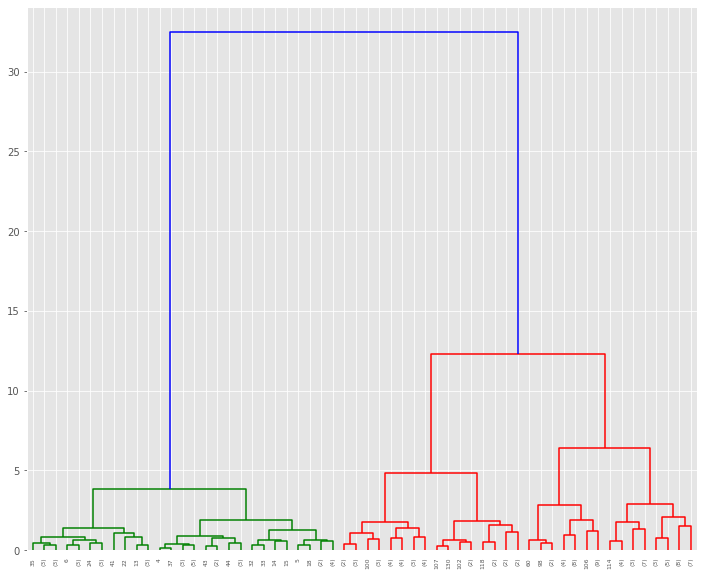

In [55]:
# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(n_clusters=None, affinity='euclidean', linkage='ward',
                                memory='agglo_mem', distance_threshold=0)
model.fit(X)

plt.figure(figsize=(12,10))
plot_dendrogram(model, truncate_mode='level', p=5)

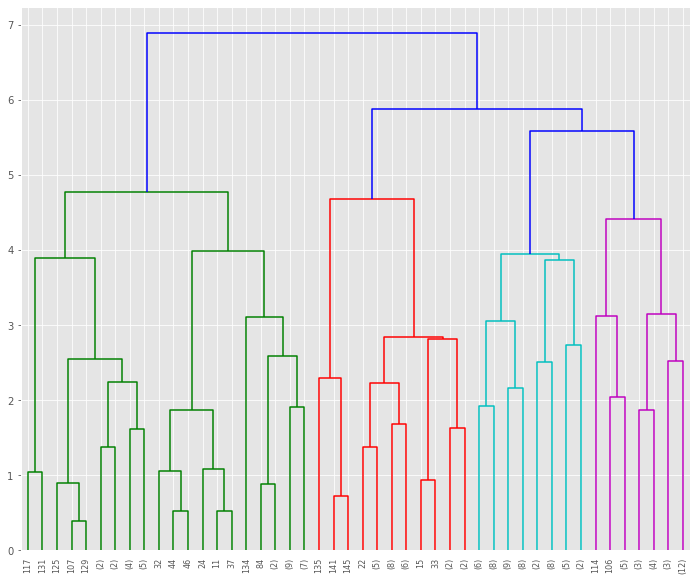

In [59]:
linked = linkage(X, method='complete', metric='mahalanobis')
fig = plt.figure(figsize=(12,10))
R = dendrogram(linked, orientation='top',
               distance_sort='descending', show_leaf_counts=True,
               truncate_mode='level', p=5)

## OPTICS

[Demo of OPTICS clustering algorithm](https://scikit-learn.org/stable/auto_examples/cluster/plot_optics.html#sphx-glr-auto-examples-cluster-plot-optics-py)

## Cluster interpretation

[How to Understand your Clustering Results](https://towardsdatascience.com/understanding-clustering-cf0117148ef4)

In [66]:
import graphviz
from sklearn.tree import DecisionTreeClassifier, export_graphviz, plot_tree

In [62]:
clust = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward', memory='agglo_mem')
labels = clust.fit_predict(X)
X['clust_labels'] = labels
X.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),clust_labels
0,5.1,3.5,1.4,0.2,1
1,4.9,3.0,1.4,0.2,1
2,4.7,3.2,1.3,0.2,1
3,4.6,3.1,1.5,0.2,1
4,5.0,3.6,1.4,0.2,1


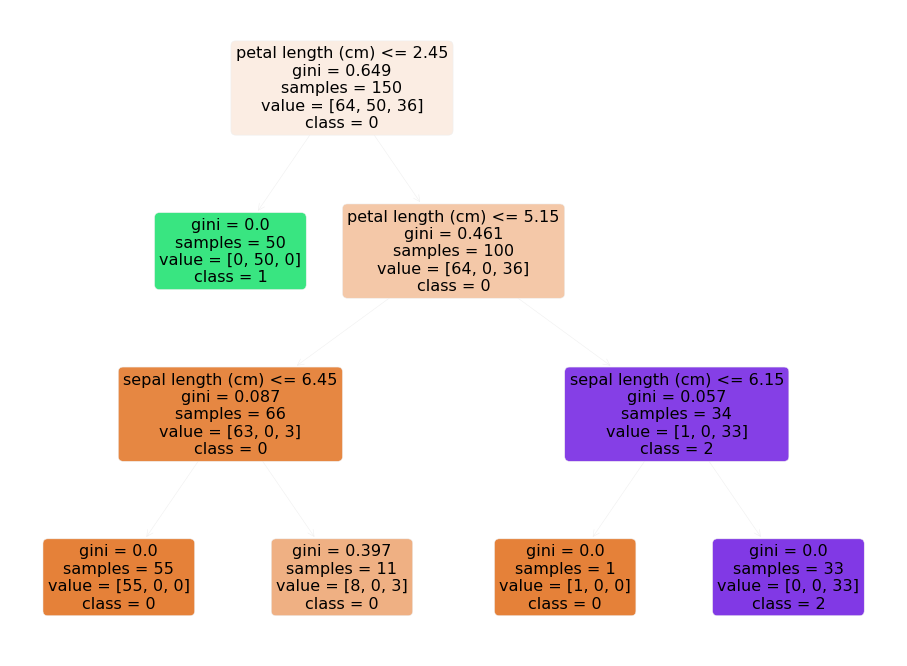

In [86]:
est = DecisionTreeClassifier(max_depth=3)
est.fit(X.iloc[:,:-1], X.iloc[:,-1])

# Must have graphviz installed
# dot_data = export_graphviz(est, out_file=None,
#                            feature_names=list(X.iloc[:,:-1].columns),
#                            filled=True, rounded=True,
#                            special_characters=True)  
# graph = graphviz.Source(dot_data)
# graph
class_names = list(map(str,sorted(X['clust_labels'].unique())))
plt.figure(figsize=(16,12))
annot = plot_tree(est, feature_names=list(X.iloc[:,:-1].columns),
                  class_names=class_names,
                  filled=True, rounded=True)